In [18]:
from setup_libs import *
import matplotlib.pyplot as plt

# 5. DecisionTree

# Дерево решений (DecisionTree)

<img src="images/tree.gif" style="background-color:white" width="600"></img>

Возьмем датасет классификации цветов.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
iris = load_iris()

Отрисуем признаки

In [20]:
data = load_iris()
df_iris = pd.DataFrame(data=np.hstack([data.data, data.target.reshape(-1,1)]), 
                       columns=data.feature_names + ['species'])
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


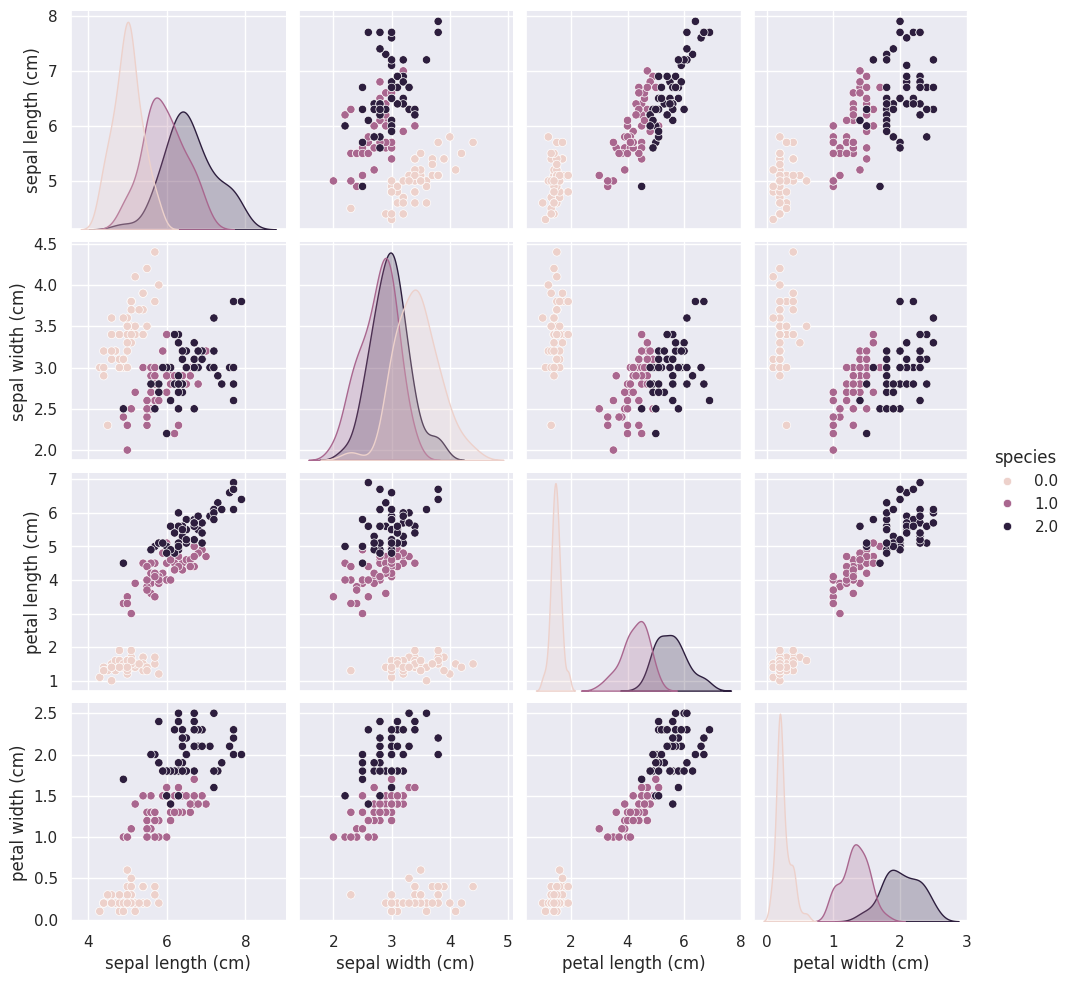

In [21]:
# Paired plot using seaborn
sns.set()
sns.pairplot(df_iris, hue="species", diag_kind="kde")

Пробуем строить деревья

* Linux `sudo apt-get install graphviz`
* Macos `brew install graphviz`
* Win качать [тут](https://graphviz.org/download/), если питон ругается, что не может найти файлы, то см. [тут](https://stackoverflow.com/a/20458620)

In [22]:
def create_tree_image(clf, figsize=(10,10)):
    from sklearn.tree import export_graphviz
    export_graphviz(clf, out_file='tree.dot', feature_names = iris.feature_names,
                    class_names = iris.target_names,
                    rounded = True, proportion = False, precision = 2, filled = True)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in python
    plt.figure(figsize = figsize)
    plt.imshow(plt.imread('tree.png'))
    plt.axis('off');
    plt.show()

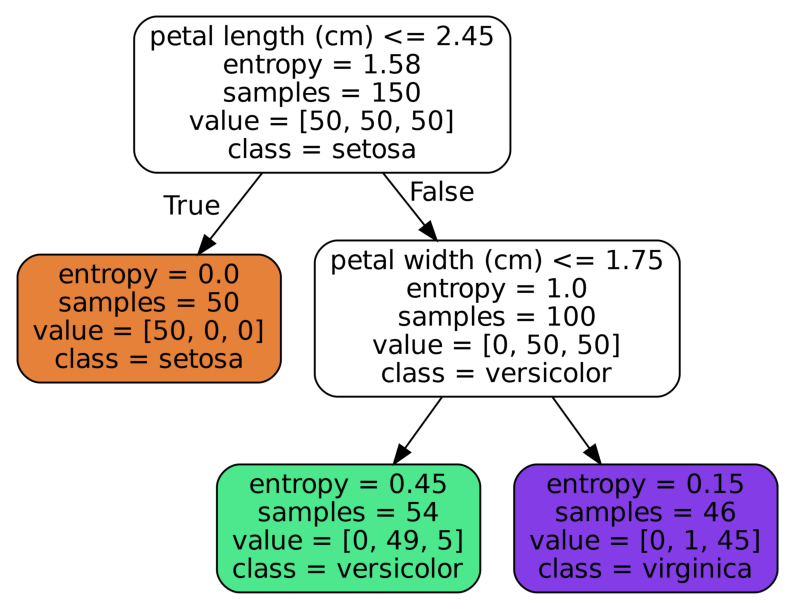

In [23]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(iris.data, iris.target)
create_tree_image(dt)

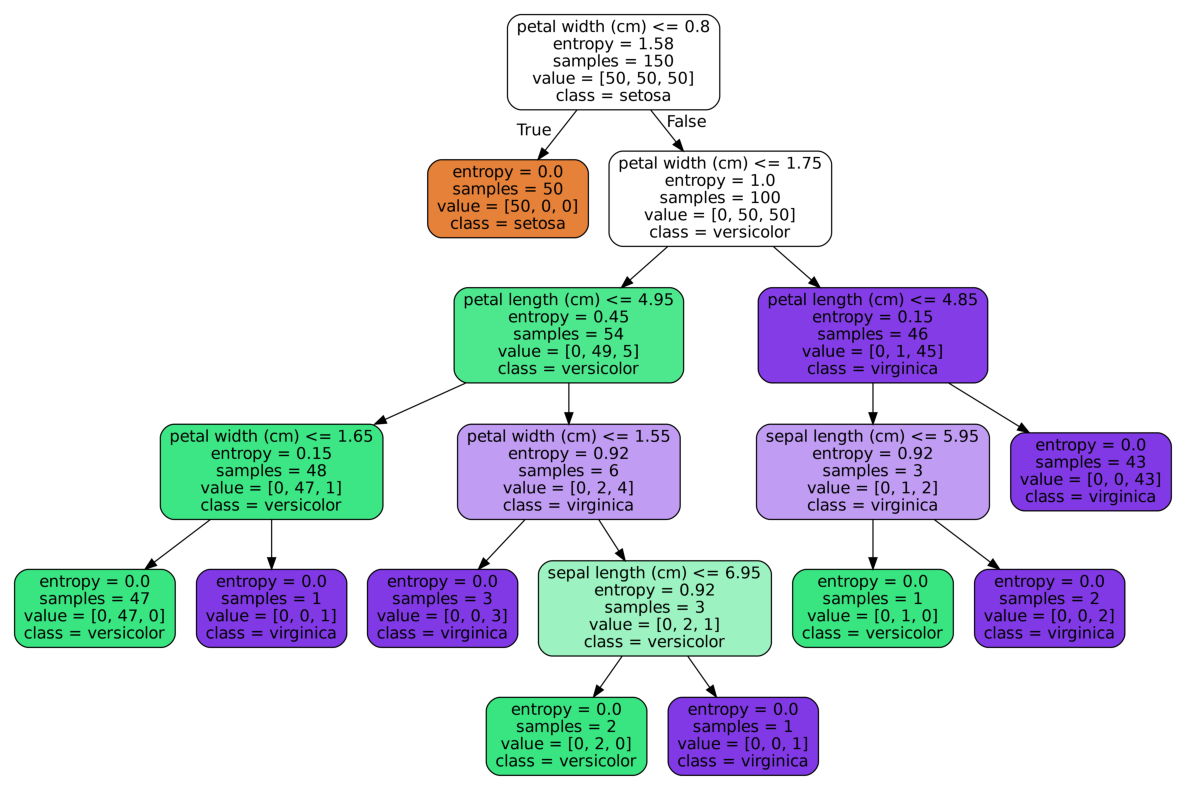

In [24]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)
dt.fit(iris.data, iris.target)
create_tree_image(dt, (16,10))

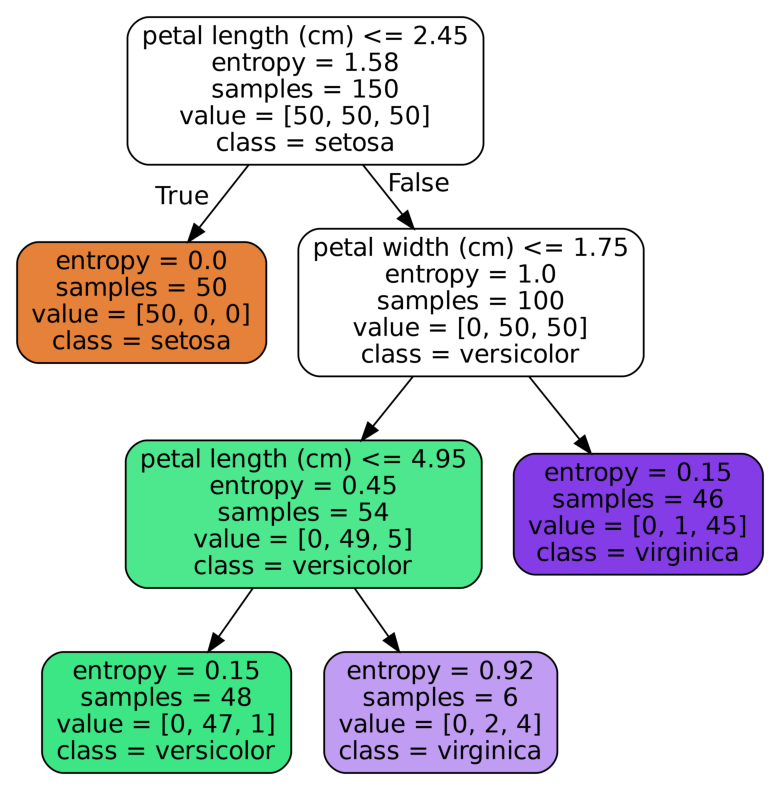

In [25]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=4)
dt.fit(iris.data, iris.target)
create_tree_image(dt)

## Как строить?

- Найдём признак, разбиение по которому на 2 подгруппы будет наилучшим.
- Повторим для каждой из групп
- Остановимся, когда улучшение будет "небольшим"

## Как строится дерево решений
**Идея:**

Один загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить "Да" или "Нет". Какой вопрос отгадывающий задаст первым делом? Тот, который сильнее всего уменьшит количество оставшихся вариантов. К примеру, вопрос "Это Анджелина Джоли?" в случае отрицательного ответа оставит более миллиона вариантов для дальнейшего перебора, а вот вопрос "Это женщина?" отсечет уже около половины знаменитостей. 

То есть, признак "пол" намного лучше разделяет выборку людей, чем признак "это Анджелина Джоли", "национальность-испанец" или "любит футбол". Это интуитивно соответствует понятию прироста информации, основанного на энтропии.

## Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот. О том, почему функция, отражающая интуицию, именно такая, а не иная, можно прочесть [тут](https://en.wikipedia.org/wiki/Entropy_(information_theory)#Characterization).

<h4>Пример</h4>
Будем предсказывать цвет шарика по его координате.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. 

Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. 

Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. 

В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. 

Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, **уменьшение энтропии** называют **приростом информации**. Формально прирост информации **(information gain, IG)** при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 

$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$

где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации получился 

$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$

Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.  
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>

In [26]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier(max_depth=10)

DecisionTreeClassifier(max_depth=10)

## Переобучение

Если доводим дерево **до конца**, мы получаем дерево идеально подстроившееся под конкретную выборку, что может плохо работать на произвольных данных. Чтобы такого не происходило, используют отсечение по количеству листов (`max_leaf_nodes`),по глубине дерева (`max_depth`)  и др.

## Алгоритм построения дерева

Основной алгоритм мы уже описали выше - [ID3](https://ru.wikipedia.org/wiki/ID3_(%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC))

Дерево строится **жадно**: на каждом шаге выбирается тот признак, при разделении по которому **прирост информации** оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине.

```python
def _build_tree(self, X, y, depth):
    split_feature, split_value = self.find_best_split(X, y)

    left_inds = X[:, split_feature] <= split_value
    right_inds = X[:, split_feature] > split_value

    left_tree = self._build_tree(X[left_inds], y[left_inds], depth + 1)
    right_tree = self._build_tree(X[right_inds], y[right_inds], depth + 1)
    
    return {'val': (split_feature, split_value), 'leaf': False,
            'left': left_tree, 'right': right_tree}
```

Есть более крутой - [C4.5](https://ru.wikipedia.org/wiki/C4.5), но он уже на самостоятельный разбор.

А если есть желание взглянуть на то, как фактически строятся деревья в современных фреймворках машинного обучения, можно почитать [доку](https://catboost.ai/en/docs/concepts/algorithm-score-functions#optimal-tree-structure) CatBoost.

## Другие критерии качества разбиения. Индекс Джини.

**Неопределенность Джини (Gini impurity)**  $$G = 1 - \sum\limits_k (p_k)^2$$

Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве.

Прирост информации выполняется аналогично:

$$ IG(Q) = G_O - \sum_{i=1}^{q}\frac{|N_i|}{N}G_i,$$
 
В случае бинарной классификации ($p_+$ – вероятность объекта иметь метку `+`(1) и `-`(0)) энтропия и неопределенность Джини примут следующий вид:<br><br>
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$$

Когда мы построим графики этих двух функций от аргумента $p_+$, то увидим, что график энтропии очень близок к графику удвоенной неопределенности Джини, и поэтому на практике эти два критерия работают *почти* одинаково.

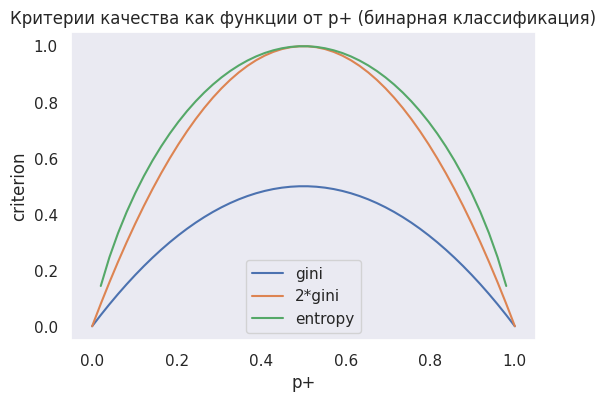

In [27]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.grid()
plt.legend()
plt.show()

## Основные параметры дерева

Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*,  про нее чуть ниже.


## Дерево решений в задаче регрессии
 
 При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества: 
 
 - Дисперсия вокруг среднего: $$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$
 где $\ell$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

#### Пример
Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c некоторым шумом.

In [28]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [29]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=10, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

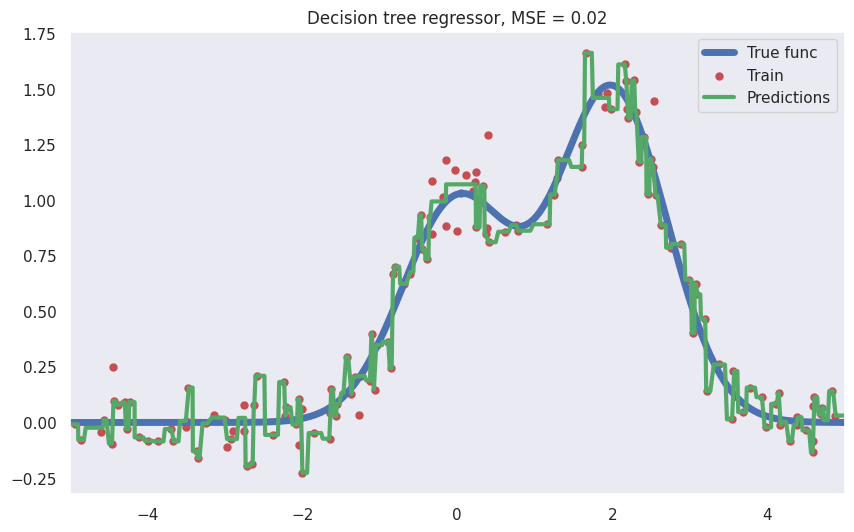

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b", lw=5, label='True func')
plt.scatter(X_train, y_train, c="r", s=25, label='Train')
plt.plot(X_test, reg_tree_pred, "g", lw=3, label='Predictions')
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.grid()
plt.legend()
plt.show()

Видим, что дерево решений аппроксимирует зависимость в данных кусочно-постоянной функцией. 

# Полезные ссылки

- [Энтропия и деревья принятия решений](https://habr.com/en/post/171759/)
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [kNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)
- [Критерий Джини](https://alexanderdyakonov.wordpress.com/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/)
- [Дискретиация признаков](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/)
- [Дискретизация признаков 2](http://clear-lines.com/blog/post/Discretizing-a-continuous-variable-using-Entropy.aspx)

## Источники материалов
* [mlcourse.ai](https://github.com/Yorko/mlcourse.ai) - курс Машинного обучения с OpenDataScience
* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)
* [МЛ в МГУ](https://github.com/esokolov/ml-course-msu)